In [1]:
import os
import json

import numpy as np
import pandas as pd
from qiskit.circuit.library import XXPlusYYGate
from qiskit import QuantumCircuit
import git
repo_path = git.Repo('.', search_parent_directories=True).working_tree_dir

In [31]:
def apply_op(qc, op):
    if op['name'] == "RY":
        (q,) = op['qubits']
        qc.ry(op['param'], q)
    elif op['name'] == "RX":
        (q,) = op['qubits']
        qc.rx(op['param'], q)
    elif op['name'] == "RZ":
        (q,) = op['qubits']
        qc.rz(op['param'], q)
    elif op['name'] == "CRY":
        c, t = op['qubits']
        qc.cry(op['param'], c, t)
    elif op['name'] == "XXPlusYY":
        a, b = op['qubits']
        beta = -np.pi/2 if op['beta'] is None else op['beta']
        qc.append(XXPlusYYGate(op['param'], beta), [a, b])
    else:
        raise ValueError(f"Unknown op {op['name']}")
    
def build_ansatz(num_qubits, basis_state, ops):

    qc = QuantumCircuit(num_qubits)
    for q, bit in enumerate(basis_state):
        if bit:
            qc.x(q)

    for op in ops:
        apply_op(qc, op)

    return qc

In [80]:
potential = 'linear'
bc = 'dirichlet'
N = 3

folder_path = os.path.join(repo_path, r"SUSY\Wess-Zumino\Qiskit\AVQE\Files", bc, potential, f"N{N}")
file_paths = os.listdir(folder_path)
json_files = [f for f in file_paths if f.endswith('.json')]

In [81]:
for file in json_files:

        data_path = os.path.join(folder_path, file)

        with open(data_path, 'r') as file:
                data = json.load(file)

        cutoff = data['cutoff']
        potential = data['potential']
        energies = data['all_energies']
        basis_state = data['basis_state']
        num_qubits = int(data['N']*(1+np.log2(cutoff)))

        op_list = data['op_list'][0]
        pruned = []
        n=1e-6
        pruned = [g for g in op_list if abs(float(g["param"])) > n]

        qc = build_ansatz(num_qubits, basis_state, pruned)

        fig = qc.draw('mpl')
        save_path = os.path.join(folder_path, "circuits")
        os.makedirs(save_path, exist_ok=True)
        fig.savefig(os.path.join(save_path, f"{potential}_{cutoff}.png"), dpi=300, bbox_inches="tight")

In [75]:
def build_avqe_pattern_ansatz(
    N: int,
    cutoff: int,
    *,
    beta: float = -np.pi / 2,
    bond0_sign: int = -1,  # +1 => +pi/8 on bond 0, -1 => -pi/8 on bond 0
    include_basis: bool =True
) -> QuantumCircuit:
    """
    Pattern-only pruned ansatz inferred from your diagrams.

    XXPlusYY:
      - acts on last qubit of each site
      - nearest-neighbour chain
      - theta alternates +/- pi/8 along bonds

    RY:
      cutoff=2: none
      cutoff=4: local=1 only
        - edge sites: -0.0784
        - inner sites: -0.14
      cutoff=8: locals=1,2
        - edge sites: (-0.0784, +0.0038)
        - inner sites: (-0.14,   +0.0125)
      cutoff=16: same RY pattern as cutoff=8, but applied to locals=1,2
        (i.e., still only 2 RYs per site even though qps=5)
    """


    qps = int((1 + np.log2(cutoff)))
    n_qubits = N * qps
    qc = QuantumCircuit(n_qubits)

    def q(site: int, local: int) -> int:
        return site * qps + local

    def last(site: int) -> int:
        return q(site, qps - 1)

    def is_edge(site: int) -> bool:
        return site == 0 or site == N - 1
    
    # -------------------
    # Basis state
    # -------------------
    if include_basis:
        for s in range(N):
            want_odd = (s % 2 == 1)
            if want_odd:
                qc.x(last(s))

    # -------------------
    # RY pattern by cutoff
    # -------------------
    if cutoff == 4:
        for s in range(N):
            theta = -0.0784 if is_edge(s) else -0.14
            qc.ry(theta, q(s, 1))  # only local=1

    elif cutoff in (8, 16):
        # 2 RYs per site on locals 1 and 2
        for s in range(N):
            if is_edge(s):
                thetas = (-0.0784, 0.0038)
            else:
                thetas = (-0.14, 0.0125)
            qc.ry(thetas[0], q(s, 1))
            qc.ry(thetas[1], q(s, 2))

    # cutoff == 2: no RYs

    # -------------------
    # XXPlusYY chain
    # -------------------
    theta0 = np.pi / 8
    for b in range(N - 1):
        theta = bond0_sign * ((-1) ** b) * theta0
        qc.append(XXPlusYYGate(theta, beta), [last(b), last(b + 1)])

    return qc


In [2]:
import wesszumino as wz

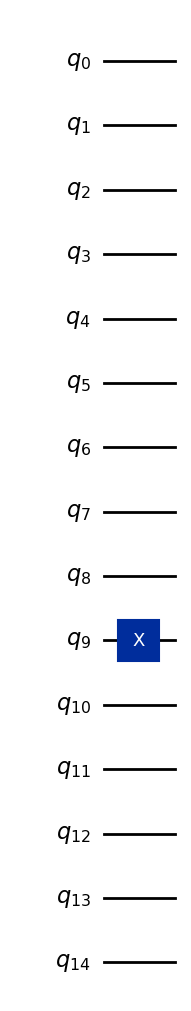

In [7]:
qc = wz.build_avqe_pattern_ansatz(
    N=3,
    cutoff=16,
    include_basis=True,
    include_rys=False,
    include_xxyys=False
)

qc.draw('mpl')
